# Инициализация весов

В данном ноутбуке мы с вами коснемся такой темы, как инициализация слоев нейронной сети с помощью различных методов, сравним их вкратце друг с другом и научимся использовать.

Как вы помните, изначально слой нейронной сети создается заполненным случайным образом. Однако, что означает - случайным? Из какого распределения эти веса взяты? И можно ли делать это эффективнее?

Как обычно, установим необходимые нам библиотеки и импортируем их.

In [ ]:
!pip install numpy tensorflow tensorflow_datasets seaborn matplotlib

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

Мы будем использовать стандатный набор данных Iris для этой задачи. Как и ранее, скачаем данный датасет и разделим его на тренировочную и тестовую выборки. 

In [2]:
ds_train, ds_test = tfds.load(
    name='iris',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True
)

input_shape = (4, )  
batch_size = 10      
amount_of_classes = 3

def make_one_hot(x, y):
    return x, tf.one_hot(y, depth=amount_of_classes)

ds_train = (
    ds_train
    .map(make_one_hot)
    .shuffle(len(ds_train))
    .batch(batch_size, drop_remainder=True)
)
    
ds_test = (
    ds_test
    .map(make_one_hot)
    .batch(batch_size, drop_remainder=True)
)

2022-07-23 17:04:32.599442: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/150 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/iris/2.0.0.incompleteA07EZQ/iris-train.tfrecord*...:   0%|          | 0/150 [0…

Dataset iris downloaded and prepared to ~/tensorflow_datasets/iris/2.0.0. Subsequent calls will reuse this data.
Metal device set to: Apple M1 Pro


2022-07-23 17:04:34.690476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-23 17:04:34.690685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Итак, что же такое инициализация весов?

Для инициализации весов слоя нейронной сети существует множество стратегий. Изначально при инициализации слоя нейронной сети требовалось лишь инициализировать нейроны максимально различными значениями вокруг нуля для установления симметрии нейронов для градиентного спуска. Если несколько нейронов в одном слое инициализированы одинаковыми значениями, то к ним могут приходить одинаковые градиенты, и оба нейрона будут действовать как один. Это снижает число активных нейронов в слое, чего мы хотим избежать.

Однако, по прошествии времени авторы различных статей заметили, что инициализация может влиять на процесс обучения и итоговый результат. В различных статьях были представлены разные стратегии инициализации слоев: от использования различных распределений до инициализации слоев последовательно с учетом предыдущих. Давайте сравним несколько из них и попытаемся понять, какие из них стоит использовать, а какие — нет.

В фреймворке TensorFlow все инициализаторы весов сгруппированы в модуле keras.initializers. Подробнее о них можно прочитать по следующим ссылкам:
 - https://keras.io/api/layers/initializers/  
 - https://www.tensorflow.org/api_docs/python/tf/keras/initializers  
 
 
Импортируем данный модуль.

In [3]:
import tensorflow.keras.initializers as inits

Давайте создадим функцию, которая будет принимать инциализатор весов и возвращать модель с слоями, инициализированными данным способом. Все остальные параметры у моделей для чистоты эксперимента оставим одинаковыми.

In [4]:
def create_model(initializer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=input_shape, batch_size=batch_size))
    model.add(Dense(32, activation='sigmoid', kernel_initializer=initializer))
    model.add(Dense(16, activation='sigmoid', kernel_initializer=initializer))
    model.add(Dense(amount_of_classes, activation='softmax', kernel_initializer=initializer))

    model.compile(
        optimizer=Adam(learning_rate=0.003),
        loss=CategoricalCrossentropy(),
        metrics=[CategoricalAccuracy()]
    )
    
    return model

Итак, давайте выберем различные инициализаторы весов и соберем их в единый словарь, откуда потом будем использовать.

In [5]:
initializers = {
    "Zeros": inits.Zeros(),                            # Просто нули. Как вы думаете, выучится ли наша модель в данном случае?
    "Orthogonal": inits.Orthogonal(),                  # Ортогональная матрица весов
    "GlorotNormal": inits.GlorotNormal(),              # Нормальное распределение, предложенное Xavier Glorot
    "GlorotUniform": inits.GlorotUniform(),            # Равномерное распределение, предложенное Xavier Glorot
    "HeNormal": inits.HeNormal(),                      # Нормальное распределение, предложенное He и др.
    "HeUniform": inits.HeUniform(),                    # Равномерное распределение, предложенное He и др.
    "LecunNormal": inits.LecunNormal(),                # Нормальное распределение, предложенное Yann LeCun
    "LecunUniform": inits.LecunUniform(),              # Равномерное распределение, предложенное Yann LeCun
    "RandomNormal": inits.RandomNormal(.0, 1.0),       # Стандартное нормальное распределение
    "RandomUniform": inits.RandomUniform(-1.0, 1.0),   # Равномерное распределение [-1.0, 1.0]
}

Теперь мы можем начать проведение эксперимента. Давайте для каждого инициализатора будем создавать отдельную модель и тренировать ее на нашем наборе данных, а затем сохранять историю тренировки в словаре под соответствующим ключом.

In [6]:
last_steps = {}
EPOCHS = 10

for key, init in initializers.items():
    model = create_model(init)
    history = model.fit(ds_train, epochs=EPOCHS, validation_data=ds_test, verbose=0)
    last_steps[key] = history.history

2022-07-23 17:08:07.891471: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-23 17:08:07.891634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-23 17:08:08.200244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-23 17:08:09.335276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-23 17:08:09.488568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-23 17:08:10.547783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-23 17:08:10.699513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

Итак, теперь мы можем построить графики для функции потерь на тренировочном и тестовом датасете, а также для значений точности на тренировочном и тестовом датасете. Изучите эти графики и ответьте на вопросы:
 - Какой наименее эффективный способ инициализации весов нейронной сети?
 - Какой наиболее эффективный способ инициализации весов нейронной сети в данной задаче и условиях?
 - Насколько эффективны стандартное нормальное и равномерное распределения?
 - Какой инициализатор по умолчанию задан в фреймворке keras?

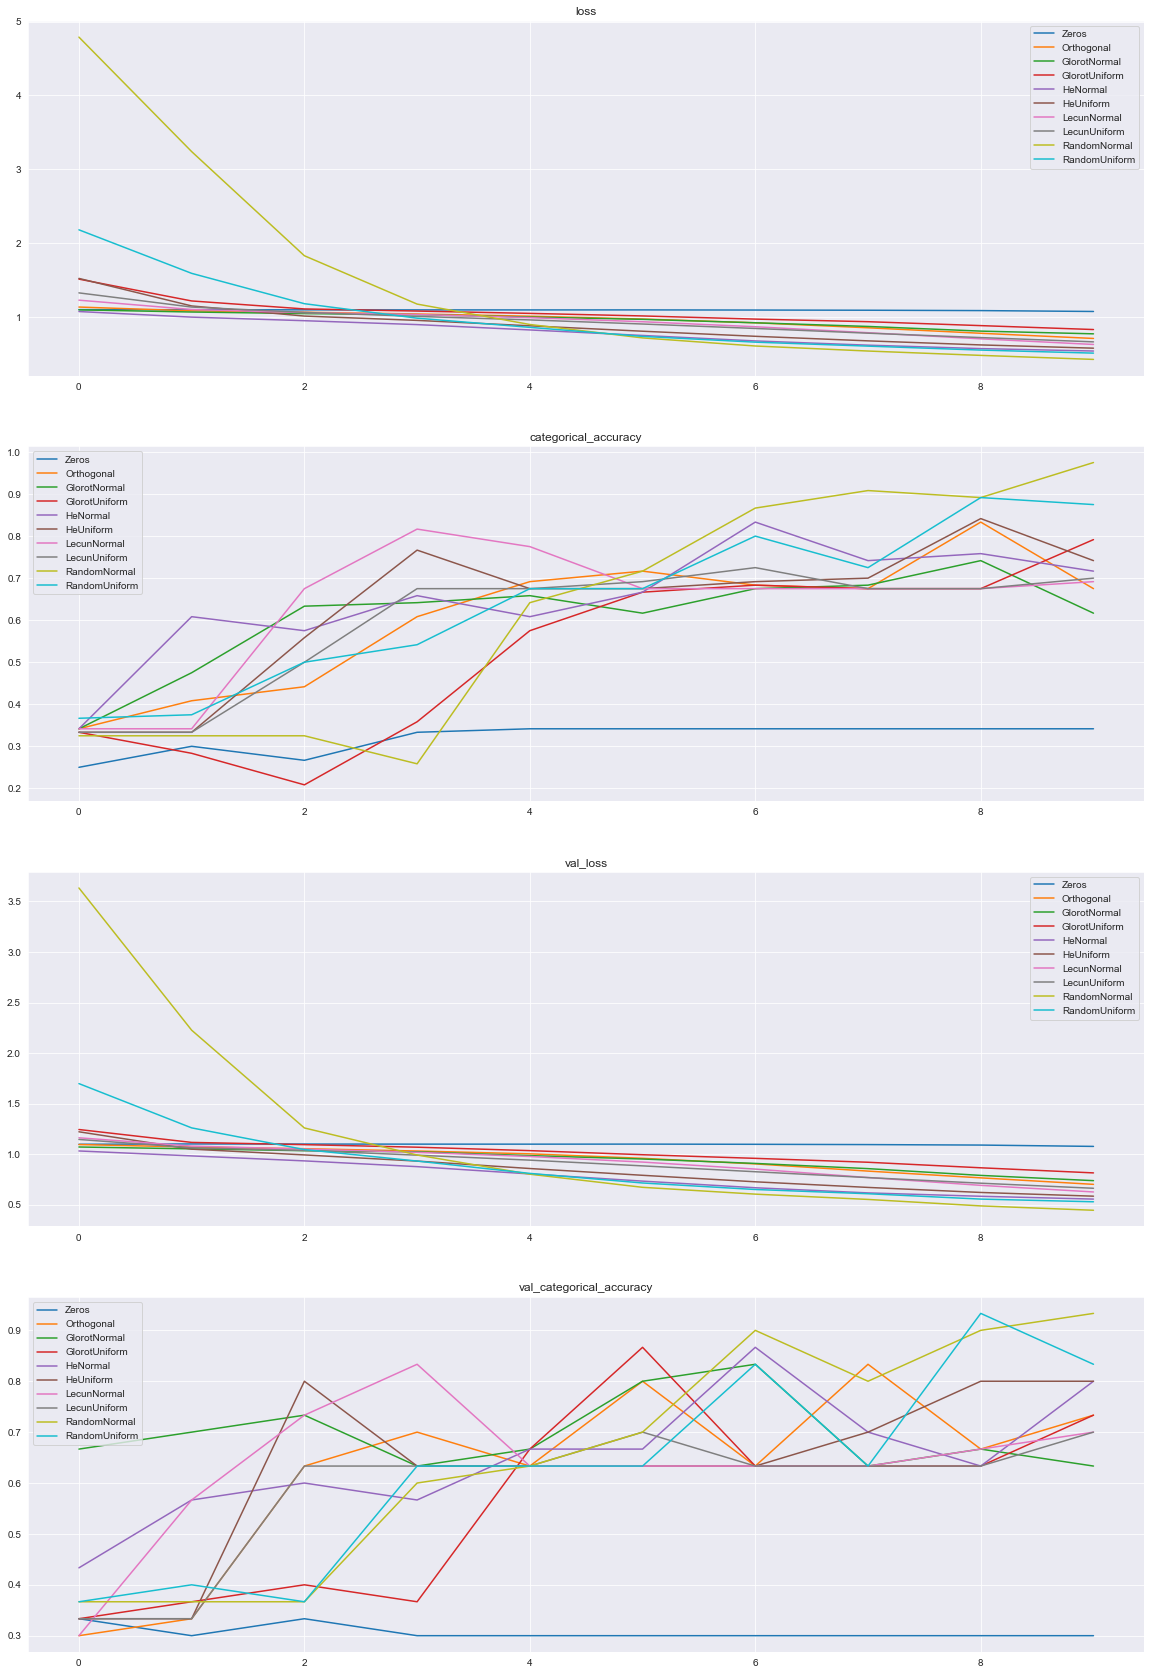

In [7]:
plt.rcParams['figure.figsize'] = [20, 30]

sns.set_style("darkgrid")
fig, axarr = plt.subplots(4, 1)
for i, graph in enumerate(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy']):
    for value in last_steps.values():
        axarr[i].plot(range(EPOCHS), value[graph])
        axarr[i].legend(last_steps.keys())
        axarr[i].set_title(graph)
plt.show()

Как итог, стоит отметить, что в настоящий момент нет единственного универсального метода инициализации, который будет наиболее эффективен всегда. Выбор инициализатора — это такой же гиперпараметр, как и количество слоев, нейронов в слое, learning rate, и так далее. Под каждую из задач стоит пробовать разные методы инициализации, так как никогда не знаешь, какой из них будет самым эффективным в текущих условиях.